In [42]:
%pip install pandas
%pip install openpyxl
%pip install scikit-learn
%pip install matplotlib


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 7.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.6 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.3/249.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 4.5 MB/s eta 

In [39]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

###############################################################################
# PART A: AUTOMATED METADATA SCAN TO BUILD DROP LISTS
###############################################################################
# Load metadata files from the Documentation folder.
demo_change_list = pd.read_csv("Documentation/DemoStats 2024 - Variables Change List.csv")
demo_list = pd.read_csv("Documentation/DemoStats 2024 - Variables List.csv")
household_change_list = pd.read_excel("Documentation/HouseholdSpend 2024 - Variables Change List.xlsx")
household_list = pd.read_excel("Documentation/HouseholdSpend 2024 - Variables List.xlsx")

# Define search keywords.
search_terms = ["pension", "retirement", "insurance"]

# Function to search for keywords in given columns.
def find_keywords(df, cols, terms):
    results = []
    for _, row in df.iterrows():
        for col in cols:
            val = str(row.get(col, "")).lower()
            for term in terms:
                if term in val:
                    results.append(row.get("Variable", ""))
    return results

# Search each metadata file.
demo_pens_1 = find_keywords(demo_change_list, ["Variable", "Description", "Category"], search_terms)
demo_pens_2 = find_keywords(demo_list, ["Variable", "Description", "Hierarchy Description", "Category"], search_terms)
house_pens_1 = find_keywords(household_change_list, ["Variable", "Description", "Category"], search_terms)
house_pens_2 = find_keywords(household_list, ["Variable", "Description", "Category", "Consumption"], search_terms)

# Build drop lists for pension/retirement/insurance columns.
demo_pens_vars = sorted(set(demo_pens_1 + demo_pens_2))
house_pens_vars = sorted(set(house_pens_1 + house_pens_2))

# Find "No Longer Available" variables.
demo_no_longer = demo_change_list[
    demo_change_list["Change Type"].str.lower().str.contains("no longer available")
]["Variable"].unique().tolist()
house_no_longer = household_change_list[
    household_change_list["Change Type"].str.lower().str.contains("no longer available")
]["Variable"].unique().tolist()

# Build the final drop lists.
demo_all_drops = sorted(set(demo_pens_vars + demo_no_longer))
house_all_drops = sorted(set(house_pens_vars + house_no_longer))

print("DemoStats drop list:", demo_all_drops)
print("HouseholdSpend drop list:", house_all_drops)

###############################################################################
# PART B: LOAD ORIGINAL DATA, DROP UNWANTED COLUMNS, MERGE, AND SAMPLE
###############################################################################
# Load the original data files from the Coursework Data folder.
df_demo_orig = pd.read_csv("Coursework Data/Demostats.csv")
df_household_orig = pd.read_csv("Coursework Data/HouseholdSpend.csv")

# Drop the automatically discovered columns.
df_demo_clean = df_demo_orig.drop(columns=demo_all_drops, errors="ignore")
df_household_clean = df_household_orig.drop(columns=house_all_drops, errors="ignore")

# Merge on ["GEO", "CODE"].
df_merged = pd.merge(df_demo_clean, df_household_clean, on=["GEO", "CODE"], how="inner")
df_merged.drop_duplicates(inplace=True)
print("Merged shape:", df_merged.shape)

# Sample 100,000 rows for manageable processing.
df_sample = df_merged.sample(n=100000, random_state=42)
print("Sample shape:", df_sample.shape)

###############################################################################
# PART C: NUMERIC CLEANING
###############################################################################
# Drop columns with over 80% missing values.
missing_pct = df_sample.isnull().mean()
cols_to_drop = missing_pct[missing_pct > 0.8].index.tolist()
df_sample.drop(columns=cols_to_drop, inplace=True, errors="ignore")
print("Shape after dropping high-missingness columns:", df_sample.shape)

# Separate numeric and non-numeric columns.
df_numeric = df_sample.select_dtypes(include=[np.number])
df_non_numeric = df_sample.select_dtypes(exclude=[np.number])

# Median impute numeric columns.
imputer = SimpleImputer(strategy="median")
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric),
                                  columns=df_numeric.columns,
                                  index=df_numeric.index)

# Drop near-constant numeric columns (std < 1e-6).
const_cols = df_numeric_imputed.std()[df_numeric_imputed.std() < 1e-6].index.tolist()
df_numeric_imputed.drop(columns=const_cols, inplace=True)

# Winsorize numeric columns using IQR (cap outliers).
def winsorize_IQR(df, multiplier=1.5):
    df_w = df.copy()
    for col in df_w.columns:
        Q1 = df_w[col].quantile(0.25)
        Q3 = df_w[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - multiplier * IQR
        high = Q3 + multiplier * IQR
        df_w[col] = df_w[col].clip(lower=low, upper=high)
    return df_w

df_numeric_winsorized = winsorize_IQR(df_numeric_imputed, multiplier=1.5)

# Standard scale the numeric columns.
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric_winsorized),
                                 columns=df_numeric_winsorized.columns,
                                 index=df_numeric_winsorized.index)

# Reattach non-numeric columns.
df_non_numeric_filtered = df_non_numeric.loc[df_numeric_scaled.index]
df_final_for_clustering = pd.concat([df_non_numeric_filtered, df_numeric_scaled], axis=1)

print("Final shape for clustering:", df_final_for_clustering.shape)
print(df_final_for_clustering.head())


DemoStats drop list: ['ECYCFSC1C', 'ECYCFSC2C', 'ECYCFSC3C', 'ECYCFSCL1C', 'ECYCFSCL2C', 'ECYCFSCL3C', 'ECYCFSFP1C', 'ECYCFSFP2C', 'ECYCFSFP3C', 'ECYCFSLP1C', 'ECYCFSLP2C', 'ECYCFSLP3C', 'ECYCFSM1C', 'ECYCFSM2C', 'ECYCFSM3C', 'ECYCFSMP1C', 'ECYCFSMP2C', 'ECYCFSMP3C', 'ECYHFSC1C', 'ECYHFSC2C', 'ECYHFSC3C', 'ECYHFSCL1C', 'ECYHFSCL2C', 'ECYHFSCL3C', 'ECYHFSFP1C', 'ECYHFSFP2C', 'ECYHFSFP3C', 'ECYHFSLP1C', 'ECYHFSLP2C', 'ECYHFSLP3C', 'ECYHFSM1C', 'ECYHFSM2C', 'ECYHFSM3C', 'ECYHFSMP1C', 'ECYHFSMP2C', 'ECYHFSMP3C', 'ECYINDFINA', 'ECYMTN75P', 'ECYPIM0105', 'ECYPIM0610', 'ECYPIM1116', 'ECYPIM17CY', 'EHYCFSC1C', 'EHYCFSC2C', 'EHYCFSC3C', 'EHYCFSCL1C', 'EHYCFSCL2C', 'EHYCFSCL3C', 'EHYCFSFP1C', 'EHYCFSFP2C', 'EHYCFSFP3C', 'EHYCFSLP1C', 'EHYCFSLP2C', 'EHYCFSLP3C', 'EHYCFSM1C', 'EHYCFSM2C', 'EHYCFSM3C', 'EHYCFSMP1C', 'EHYCFSMP2C', 'EHYCFSMP3C', 'EHYHFSC1C', 'EHYHFSC2C', 'EHYHFSC3C', 'EHYHFSCL1C', 'EHYHFSCL2C', 'EHYHFSCL3C', 'EHYHFSFP1C', 'EHYHFSFP2C', 'EHYHFSFP3C', 'EHYHFSLP1C', 'EHYHFSLP2C', 'EHYHF

Matplotlib is building the font cache; this may take a moment.


k = 2: Inertia = 32255758.29, Silhouette Score = 0.497
k = 3: Inertia = 26057977.13, Silhouette Score = 0.317
k = 4: Inertia = 23889292.57, Silhouette Score = 0.224
k = 5: Inertia = 22948666.77, Silhouette Score = 0.163
k = 6: Inertia = 22277476.12, Silhouette Score = 0.150
k = 7: Inertia = 21581512.73, Silhouette Score = 0.134
k = 8: Inertia = 20975751.57, Silhouette Score = 0.131
k = 9: Inertia = 20518042.00, Silhouette Score = 0.132
k = 10: Inertia = 20136721.68, Silhouette Score = 0.134


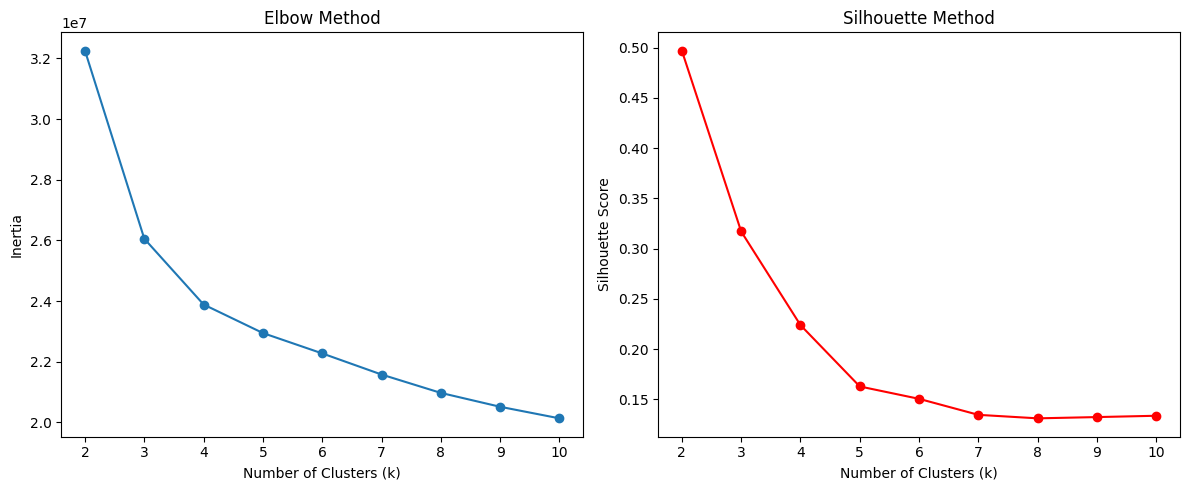

In [43]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assume df_final_for_clustering is your cleaned DataFrame from Part 1.
# Use only the numeric columns for clustering:
X = df_final_for_clustering.select_dtypes(include=[np.number])

# Define a range for the number of clusters to test.
cluster_range = range(2, 11)  # Testing for k=2 to k=10 clusters.
inertias = []           # For the elbow method.
silhouette_scores = []  # For the silhouette method.

# Run KMeans for each k, record the inertia and silhouette score.
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"k = {k}: Inertia = {kmeans.inertia_:.2f}, Silhouette Score = {sil_score:.3f}")

# Plot the results: elbow plot (inertia vs. number of clusters)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(cluster_range), inertias, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot the silhouette score vs. number of clusters.
plt.subplot(1, 2, 2)
plt.plot(list(cluster_range), silhouette_scores, marker='o', linestyle='-', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")

plt.tight_layout()
plt.show()


# Optimal Number of Clusters: Elbow & Silhouette Methods

To determine the optimal number of clusters, two methods were employed:

## Elbow Method (Inertia)
The *inertia* is defined as the sum of squared distances between samples and their nearest cluster centroid. In this analysis, inertia was calculated for various values of \( k \) (from 2 to 10 clusters). The results indicate:

- A significant drop in inertia is observed when moving from \( k = 2 \) (inertia ≈ 32,255,758) to \( k = 3 \) (inertia ≈ 26,057,977).
- Beyond \( k = 3 \), the rate of decrease in inertia diminishes, which suggests that adding more clusters yields progressively smaller improvements in explaining data variance.

In general, one seeks an “elbow” in the inertia plot—a point where further increases in \( k \) do not lead to substantial reductions in inertia. In this case, the elbow appears around \( k = 3 \) or possibly \( k = 4 \).

## Silhouette Method
The *silhouette score* measures how similar an object is to its own cluster compared to other clusters, with values ranging from \(-1\) to \( 1 \). A higher silhouette score indicates better-defined, more distinct clusters. According to the results:

- The highest silhouette score is achieved at \( k = 2 \) (0.497).
- The silhouette score drops significantly to 0.317 at \( k = 3 \) and declines further as \( k \) increases.

This indicates that, in terms of cluster separation, a 2-cluster solution produces the most distinct grouping of data points.

## Conclusion
The two methods provide somewhat different recommendations:

- The **Elbow Method** suggests that additional clusters (around \( k = 3 \) or \( k = 4 \)) reduce inertia, but with diminishing returns.
- The **Silhouette Method** clearly favors a 2-cluster solution due to the highest average silhouette score.

**Formal Conclusion:**  
If the primary objective is to obtain well-separated, distinct clusters, the silhouette analysis indicates that \( k = 2 \) is optimal. However, if a finer segmentation is desired—even though it results in lower silhouette scores—one might choose \( k = 3 \) (or \( k = 4 \)). In this case, the evidence leans towards a 2-cluster solution as it yields the highest silhouette score, thereby indicating clearer separation between clusters.
